<a href="https://colab.research.google.com/github/Kits1700/WaterEnergy/blob/main/Electricity2_LSTM%2BRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

In [ ]:
# load all data
dataset = read_csv('/content/drive/My Drive/WaterEnergy/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [ ]:
# mark all missing values
from numpy import nan
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

In [ ]:

# fill missing values with a value at the same time one day ago
from numpy import isnan
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]


In [ ]:


# fill missing
fill_missing(dataset.values)


In [ ]:
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [ ]:
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [ ]:

# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')


(1442, 8)
            Global_active_power  ...  sub_metering_4
datetime                         ...                
2006-12-16             1209.176  ...    14680.933319
2006-12-17             3390.460  ...    36946.666732
2006-12-18             2203.826  ...    19028.433281
2006-12-19             1666.194  ...    13131.900043
2006-12-20             2225.748  ...    20384.800011

[5 rows x 8 columns]


In [ ]:
df['datetime'] = df['datetime'].astype(float)

KeyError: ignored

In [ ]:
import pandas as pd
from datetime import datetime

dataset = pd.read_csv('household_power_consumption_days.csv')

X = (dataset['Global_active_power'].values)
y = dataset['Sub_metering_1'].values
dataset.head(10)





FileNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [ ]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = regressor.predict(X_test.reshape(-1,1))

In [ ]:
df = pd.DataFrame({'Real Values':y_test.reshape(-1), 'Predicted Values':y_pred.reshape(-1)})
df

,Real Values,Predicted Values
0,1136.0,10932.0
1,1067.0,1415.8
2,1071.0,2889.6
3,1038.0,1664.8
4,1775.0,3385.1
...,...,...
68,2420.0,1444.4
69,2273.0,934.2
70,1083.0,1120.0
71,1180.0,381.2


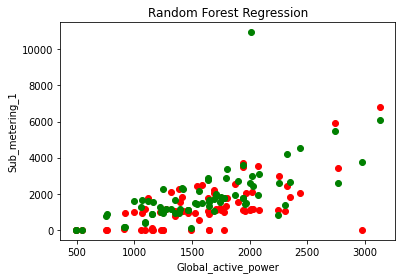

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X_test, y_test, color = 'red')
plt.scatter(X_test, y_pred, color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Global_active_power')
plt.ylabel('Sub_metering_1')
plt.show()

In [ ]:

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [ ]:


# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [ ]:




# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [ ]:


# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [ ]:

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 

lstm: [397.458] 402.8, 429.2, 379.8, 385.4, 398.4, 321.5, 452.2


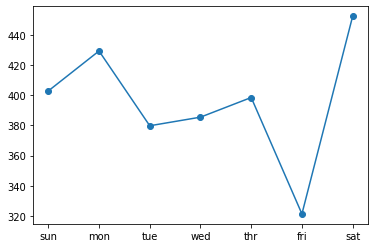

In [ ]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False
    

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
from pandas import read_csv
series = read_csv('/content/drive/My Drive/WaterEnergy/water.csv', header=0, index_col=0)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

Dataset 69, Validation 10


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)


>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=522
>Predicted=522.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=503
>Predicted=503.000, Expected=450
>Predicted=450.000, Expected=432
>Predicted=432.000, Expected=432
>Predicted=432.000, Expected=458
>Predicted=458.000, Expected=462
>Predicted=462.000, Expected=503
>Predicted=503.000, Expected=488
>Predicted=488.000, Expected=466
>Predicted=466.000, Expected=492
>Predicted=492.000, Expected=503
>Predicted=503.000, Expected=515
>Predicted=515.000, Expected=500
>Predicted=500.000, Expected=522
>Predicted=522.000, Expected=575
>Predicted=575.000, Expected=583
>Predicted=583.000, Expected=587
>Predicted=587.000, Expected=628
>Predicted=628.000, Expected=640
>Predicted=640.000, Expected=609
>Predicted=609.000, Expected=606
>Predicted=606.000, Expected=632
>Predicted=632.000, Expected=617
>Predicted=617.000, Expected=613
>Predicted=613.000, Expected=598
>Predicted

In [ ]:

from pandas import read_csv
series = read_csv('dataset.csv')
print(series.describe())


              356
count   68.000000
mean   502.602941
std     72.296888
min    344.000000
25%    458.000000
50%    496.000000
75%    540.750000
max    662.000000


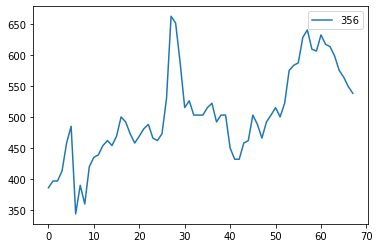

In [ ]:

from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv')
series.plot()
pyplot.show()

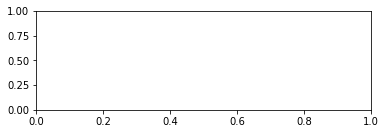

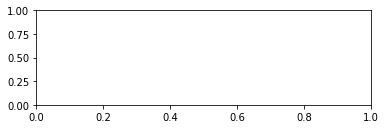

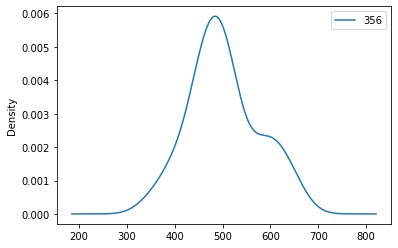

In [ ]:

from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv')
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

In [ ]:


from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv')
groups = series[1885:1944].groupby(Grouper(freq='10AS'))
decades = DataFrame()
for name, group in groups:
	decades[name.year] = group.values
decades.boxplot()
pyplot.show()

TypeError: ignored

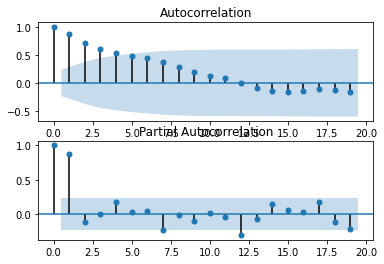

In [ ]:

from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('dataset.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [ ]:

from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = read_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=506.545, Expected=503
>Predicted=506.441, Expected=515
>Predicted=518.686, Expected=522
>Predicted=525.778, Expected=492
>Predicted=494.865, Expected=503
>Predicted=506.079, Expected=503
>Predicted=506.000, Expected=450
>Predicted=451.600, Expected=432
>Predicted=433.122, Expected=432
>Predicted=433.095, Expected=458
>Predicted=459.674, Expected=462
>Predicted=463.727, Expected=503
>Predicted=505.600, Expected=488
>Predicted=490.217, Expected=466
>Predicted=467.702, Expected=492
>Predicted=494.208, Expected=503
>Predicted=505.388, Expected=515
>Predicted=517.580, Expected=500
>Predicted=502.235, Expected=522
>Predicted=524.615, Expected=575
>Predicted=578.566, Expected=583
>Predicted=586.648, Expected=587
>Predicted=590.655, Expected=628
>Predicted=632.321, Expected=640
>Predicted=644.456, Expected=609
>Predicted=612.845, Expected=606
>Predicted=609.729, Expected=632
>Predicted=636.100, Expected=617
>Predicted=620.787, Expected=613
>Predicted=616.661, Expected=598
>Predicted

In [ ]:
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot
# load data
series = read_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# summarise residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()